In [7]:
from modules.utils_data import load_data
from modules.plotting import plot_scatter_and_line
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import numpy as np

In [8]:
%%capture
# The previous line silences the output because I don't like it

# Load the data
df_combined = load_data()

In [9]:
# Split the train/test data
train, test = train_test_split(df_combined, test_size=0.3, random_state=42)
for col in df_combined.columns[1:]:
    print(f'{col}: {test[col].count()/df_combined[col].count()}')

LogVP: 0.3108348134991119
LogP: 0.303577830357783
LogOH: 0.3352601156069364
LogBCF: 0.27884615384615385
LogHalfLife: 0.37333333333333335
BP: 0.3094054849990797
Clint: 0.2783882783882784
FU: 0.29283489096573206
LogHL: 0.3199426111908178
LogKmHL: 0.28835489833641403
LogKOA: 0.32222222222222224
LogKOC: 0.32088520055325037
MP: 0.30270770654940987
LogMolar: 0.29888803680981596


In [10]:
# Try different dataset sizes
sizes = [0.01, 0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1]
out_dir = 'LogP_different_sizes/'
os.makedirs(out_dir, exist_ok=True)

stl_test = test[["SMILES", "LogP"]].dropna()
stl_data = train[["SMILES", "LogP"]].dropna().sample(frac=1, random_state=42) # Shuffle data
other_properties = train.drop(columns="LogP")

for s in sizes:
    os.makedirs(out_dir + f'{s}_STL', exist_ok=True)
    stl_less_data = stl_data[:int(len(stl_data)*s)]
    print("frac", s, ":", len(stl_less_data))   
    stl_less_data.to_csv(out_dir + f'{s}_STL/train.csv', index=False)
    stl_test.to_csv(out_dir + f'{s}_STL/test.csv', index=False)
    os.makedirs(out_dir + f'{s}_MTL', exist_ok=True)
    mtl_less_data = pd.merge(stl_less_data, other_properties, on="SMILES", how="outer")
    mtl_less_data.to_csv(out_dir + f'{s}_MTL/train.csv', index=False)
    test.to_csv(out_dir + f'{s}_MTL/test.csv', index=False)

properties = mtl_less_data.drop(columns='SMILES').columns.to_list()

frac 0.01 : 97
frac 0.02 : 194


frac 0.03 : 291
frac 0.04 : 388
frac 0.05 : 485
frac 0.075 : 728
frac 0.1 : 971
frac 0.2 : 1942
frac 0.3 : 2913
frac 0.4 : 3885
frac 0.5 : 4856
frac 0.75 : 7284
frac 1 : 9713


In [11]:
for s in sizes:
    # train STL
    os.system(f'''chemprop train \
    --data-path {out_dir}{s}_STL/train.csv \
    --task-type regression \
    --epochs 1 \
    --output-dir {out_dir}{s}_STL/model/ \
    --num-workers 15 ''')

    # Predict
    os.system(f'''chemprop predict \
    --test-path {out_dir}{s}_STL/test.csv \
    --model-path {out_dir}{s}_STL/model/model_0/best.pt \
    --preds-path {out_dir}{s}_STL/preds.csv \
    --num-workers 15''')

    # train MTL
    os.system(f'''chemprop train \
    --data-path {out_dir}{s}_MTL/train.csv \
    --task-type regression \
    --epochs 1 \
    --target-columns {" ".join(properties)} \
    --task-weights {" ".join([str(1) if p != "LogP" else str(10) for p in properties])} \
    --output-dir {out_dir}{s}_MTL/model/ \
    --num-workers 15 ''')

    # Predict
    os.system(f'''chemprop predict \
    --test-path {out_dir}{s}_MTL/test.csv \
    --model-path {out_dir}{s}_MTL/model/model_0/best.pt \
    --preds-path {out_dir}{s}_MTL/preds.csv \
    --num-workers 15''')

Wrote config file to LogP_different_sizes/0.01_STL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.80, got 0.79. Requested validation size of 0.10, got 0.11. Requested test size of 0.10, got 0.11. 
  warn(
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 15.34it/s, v_num=0, train_loss=0.761]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s, v_num=0, train_loss=0.761, val_loss=0.787]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.01_STL/model/model_0/checkpoints/best-epoch=0-val_loss=0.79.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.01_STL/model/model_0/checkpoints/best-epoch=0-val_loss=0.79.ckpt


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 305.51it/s]
Entire Test Set results: {'entire_test/mse': 6.383482448595448}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 94.59it/s] 
Wrote config file to LogP_different_sizes/0.01_MTL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 126.56it/s, v_num=0, train_loss=0.0831]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 204/204 [00:02<00:00, 93.32it/s, v_num=0, train_loss=0.0831, val_loss=0.422]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.01_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.42.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.01_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.42.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 348.16it/s]
Entire Test Set results: {'entire_test/mse': 1798.789983406424}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 118.74it/s]
Wrote config file to LogP_different_sizes/0.02_STL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 23.28it/s, v_num=0, train_loss=0.583]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  6.03it/s, v_num=0, train_loss=0.583, val_loss=0.659]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.02_STL/model/model_0/checkpoints/best-epoch=0-val_loss=0.66.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.02_STL/model/model_0/checkpoints/best-epoch=0-val_loss=0.66.ckpt


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 383.11it/s]
Entire Test Set results: {'entire_test/mse': 5.88880907347924}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 108.87it/s]
Wrote config file to LogP_different_sizes/0.02_MTL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 120.74it/s, v_num=0, train_loss=0.0903]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 204/204 [00:02<00:00, 89.36it/s, v_num=0, train_loss=0.0903, val_loss=0.458]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.02_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.46.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.02_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.46.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 254.59it/s]
Entire Test Set results: {'entire_test/mse': 2218.965427126855}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 132.06it/s]
Wrote config file to LogP_different_sizes/0.03_STL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 4/4 [00:00<00:00, 30.95it/s, v_num=0, train_loss=0.746]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  7.59it/s, v_num=0, train_loss=0.746, val_loss=0.563]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.03_STL/model/model_0/checkpoints/best-epoch=0-val_loss=0.56.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.03_STL/model/model_0/checkpoints/best-epoch=0-val_loss=0.56.ckpt


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 337.16it/s]
Entire Test Set results: {'entire_test/mse': 3.886079617358351}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 92.25it/s]
Wrote config file to LogP_different_sizes/0.03_MTL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 116.78it/s, v_num=0, train_loss=0.0899]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 204/204 [00:02<00:00, 87.59it/s, v_num=0, train_loss=0.0899, val_loss=0.545]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.03_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.55.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.03_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.55.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 209.79it/s]
Entire Test Set results: {'entire_test/mse': 3075.334522645787}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 117.48it/s]
Wrote config file to LogP_different_sizes/0.04_STL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 36.72it/s, v_num=0, train_loss=0.681]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 5/5 [00:00<00:00,  9.01it/s, v_num=0, train_loss=0.681, val_loss=0.622]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.04_STL/model/model_0/checkpoints/best-epoch=0-val_loss=0.62.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.04_STL/model/model_0/checkpoints/best-epoch=0-val_loss=0.62.ckpt


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 344.02it/s]
Entire Test Set results: {'entire_test/mse': 3.474545196885882}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 88.18it/s]
Wrote config file to LogP_different_sizes/0.04_MTL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 135.87it/s, v_num=0, train_loss=0.107]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 204/204 [00:02<00:00, 97.86it/s, v_num=0, train_loss=0.107, val_loss=0.572]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.04_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.57.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.04_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.57.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 234.81it/s]
Entire Test Set results: {'entire_test/mse': 3461.0501796295625}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 109/109 [00:01<00:00, 108.05it/s]
Wrote config file to LogP_different_sizes/0.05_STL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 7/7 [00:00<00:00, 45.47it/s, v_num=0, train_loss=0.332]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:00<00:00, 13.23it/s, v_num=0, train_loss=0.332, val_loss=0.658]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.05_STL/model/model_0/checkpoints/best-epoch=0-val_loss=0.66.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.05_STL/model/model_0/checkpoints/best-epoch=0-val_loss=0.66.ckpt


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.15it/s]
Entire Test Set results: {'entire_test/mse': 3.7218105104300307}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 100.69it/s]
Wrote config file to LogP_different_sizes/0.05_MTL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 120.10it/s, v_num=0, train_loss=0.111]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 204/204 [00:02<00:00, 90.52it/s, v_num=0, train_loss=0.111, val_loss=0.457]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.05_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.46.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.05_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.46.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 244.68it/s]
Entire Test Set results: {'entire_test/mse': 2554.159357750087}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 126.86it/s]
Wrote config file to LogP_different_sizes/0.075_STL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 58.20it/s, v_num=0, train_loss=0.293]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 16.80it/s, v_num=0, train_loss=0.293, val_loss=1.390]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.075_STL/model/model_0/checkpoints/best-epoch=0-val_loss=1.39.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.075_STL/model/model_0/checkpoints/best-epoch=0-val_loss=1.39.ckpt


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 376.90it/s]
Entire Test Set results: {'entire_test/mse': 2.371405688145929}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 85.54it/s]
Wrote config file to LogP_different_sizes/0.075_MTL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 127.93it/s, v_num=0, train_loss=0.105]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 204/204 [00:02<00:00, 92.63it/s, v_num=0, train_loss=0.105, val_loss=0.478]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.075_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.48.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.075_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.48.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 399.76it/s]
Entire Test Set results: {'entire_test/mse': 2401.279046612292}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 136.70it/s]
Wrote config file to LogP_different_sizes/0.1_STL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 63.82it/s, v_num=0, train_loss=0.447]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 19.77it/s, v_num=0, train_loss=0.447, val_loss=1.210]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.1_STL/model/model_0/checkpoints/best-epoch=0-val_loss=1.21.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.1_STL/model/model_0/checkpoints/best-epoch=0-val_loss=1.21.ckpt


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 366.04it/s]
Entire Test Set results: {'entire_test/mse': 2.332574370553494}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 96.76it/s]
Wrote config file to LogP_different_sizes/0.1_MTL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 127.97it/s, v_num=0, train_loss=0.0845]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 204/204 [00:02<00:00, 92.40it/s, v_num=0, train_loss=0.0845, val_loss=0.446]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.1_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.45.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.1_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.45.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 252.20it/s]
Entire Test Set results: {'entire_test/mse': 1966.4533694731335}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 109/109 [00:01<00:00, 106.94it/s]
Wrote config file to LogP_different_sizes/0.2_STL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 25/25 [00:00<00:00, 66.27it/s, v_num=0, train_loss=0.284]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 25/25 [00:00<00:00, 27.75it/s, v_num=0, train_loss=0.284, val_loss=1.040]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.2_STL/model/model_0/checkpoints/best-epoch=0-val_loss=1.04.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.2_STL/model/model_0/checkpoints/best-epoch=0-val_loss=1.04.ckpt


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 280.60it/s]
Entire Test Set results: {'entire_test/mse': 2.718606235615278}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 97.61it/s]
Wrote config file to LogP_different_sizes/0.2_MTL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 131.06it/s, v_num=0, train_loss=0.157]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 204/204 [00:02<00:00, 92.19it/s, v_num=0, train_loss=0.157, val_loss=0.417]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.2_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.42.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.2_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.42.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 282.15it/s]
Entire Test Set results: {'entire_test/mse': 1376.2749759923788}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 138.92it/s]
Wrote config file to LogP_different_sizes/0.3_STL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 37/37 [00:00<00:00, 92.09it/s, v_num=0, train_loss=0.444]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 37/37 [00:00<00:00, 42.98it/s, v_num=0, train_loss=0.444, val_loss=0.744]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.3_STL/model/model_0/checkpoints/best-epoch=0-val_loss=0.74.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.3_STL/model/model_0/checkpoints/best-epoch=0-val_loss=0.74.ckpt


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 163.48it/s]
Entire Test Set results: {'entire_test/mse': 2.6962936987890034}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 96.43it/s]
Wrote config file to LogP_different_sizes/0.3_MTL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 123.35it/s, v_num=0, train_loss=0.066]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 204/204 [00:02<00:00, 88.48it/s, v_num=0, train_loss=0.066, val_loss=0.397]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.3_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.40.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.3_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.40.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 263.64it/s]
Entire Test Set results: {'entire_test/mse': 1493.8675719822018}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 136.58it/s]
Wrote config file to LogP_different_sizes/0.4_STL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 49/49 [00:00<00:00, 100.85it/s, v_num=0, train_loss=0.211]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 49/49 [00:01<00:00, 47.73it/s, v_num=0, train_loss=0.211, val_loss=0.598]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.4_STL/model/model_0/checkpoints/best-epoch=0-val_loss=0.60.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.4_STL/model/model_0/checkpoints/best-epoch=0-val_loss=0.60.ckpt


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 384.02it/s]
Entire Test Set results: {'entire_test/mse': 2.399547158135588}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 98.71it/s]
Wrote config file to LogP_different_sizes/0.4_MTL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 120.14it/s, v_num=0, train_loss=0.0724]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 204/204 [00:02<00:00, 89.36it/s, v_num=0, train_loss=0.0724, val_loss=0.425]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.4_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.42.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.4_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.42.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 271.75it/s]
Entire Test Set results: {'entire_test/mse': 1692.7897855912422}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 129.77it/s]
Wrote config file to LogP_different_sizes/0.5_STL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 61/61 [00:00<00:00, 106.10it/s, v_num=0, train_loss=0.237]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 61/61 [00:01<00:00, 56.11it/s, v_num=0, train_loss=0.237, val_loss=0.629]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.5_STL/model/model_0/checkpoints/best-epoch=0-val_loss=0.63.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.5_STL/model/model_0/checkpoints/best-epoch=0-val_loss=0.63.ckpt


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 348.36it/s]
Entire Test Set results: {'entire_test/mse': 2.295906261803031}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 93.66it/s]
Wrote config file to LogP_different_sizes/0.5_MTL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 129.33it/s, v_num=0, train_loss=0.106]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 204/204 [00:02<00:00, 91.70it/s, v_num=0, train_loss=0.106, val_loss=0.378]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.5_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.38.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.5_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.38.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 247.48it/s]
Entire Test Set results: {'entire_test/mse': 1243.501517968973}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 115.88it/s]
Wrote config file to LogP_different_sizes/0.75_STL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 92/92 [00:00<00:00, 101.39it/s, v_num=0, train_loss=0.172]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 92/92 [00:01<00:00, 64.69it/s, v_num=0, train_loss=0.172, val_loss=0.498]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.75_STL/model/model_0/checkpoints/best-epoch=0-val_loss=0.50.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.75_STL/model/model_0/checkpoints/best-epoch=0-val_loss=0.50.ckpt


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 268.95it/s]
Entire Test Set results: {'entire_test/mse': 1.7934186961943173}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 96.55it/s]
Wrote config file to LogP_different_sizes/0.75_MTL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 118.26it/s, v_num=0, train_loss=0.239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 204/204 [00:02<00:00, 87.98it/s, v_num=0, train_loss=0.239, val_loss=0.450]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.75_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.45.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/0.75_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.45.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 365.94it/s]
Entire Test Set results: {'entire_test/mse': 1678.9864988312813}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 137.26it/s]
Wrote config file to LogP_different_sizes/1_STL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 122/122 [00:01<00:00, 120.55it/s, v_num=0, train_loss=0.161]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 122/122 [00:01<00:00, 73.89it/s, v_num=0, train_loss=0.161, val_loss=0.279]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/1_STL/model/model_0/checkpoints/best-epoch=0-val_loss=0.28.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/1_STL/model/model_0/checkpoints/best-epoch=0-val_loss=0.28.ckpt


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 309.04it/s]
Entire Test Set results: {'entire_test/mse': 0.9288670958905958}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 104.18it/s]
Wrote config file to LogP_different_sizes/1_MTL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 121.43it/s, v_num=0, train_loss=0.184]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 204/204 [00:02<00:00, 88.97it/s, v_num=0, train_loss=0.184, val_loss=0.441]


`Trainer.fit` stopped: `max_epochs=1` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/1_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.44.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_different_sizes/1_MTL/model/model_0/checkpoints/best-epoch=0-val_loss=0.44.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 300.81it/s]
Entire Test Set results: {'entire_test/mse': 1575.714005310009}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 127.18it/s]


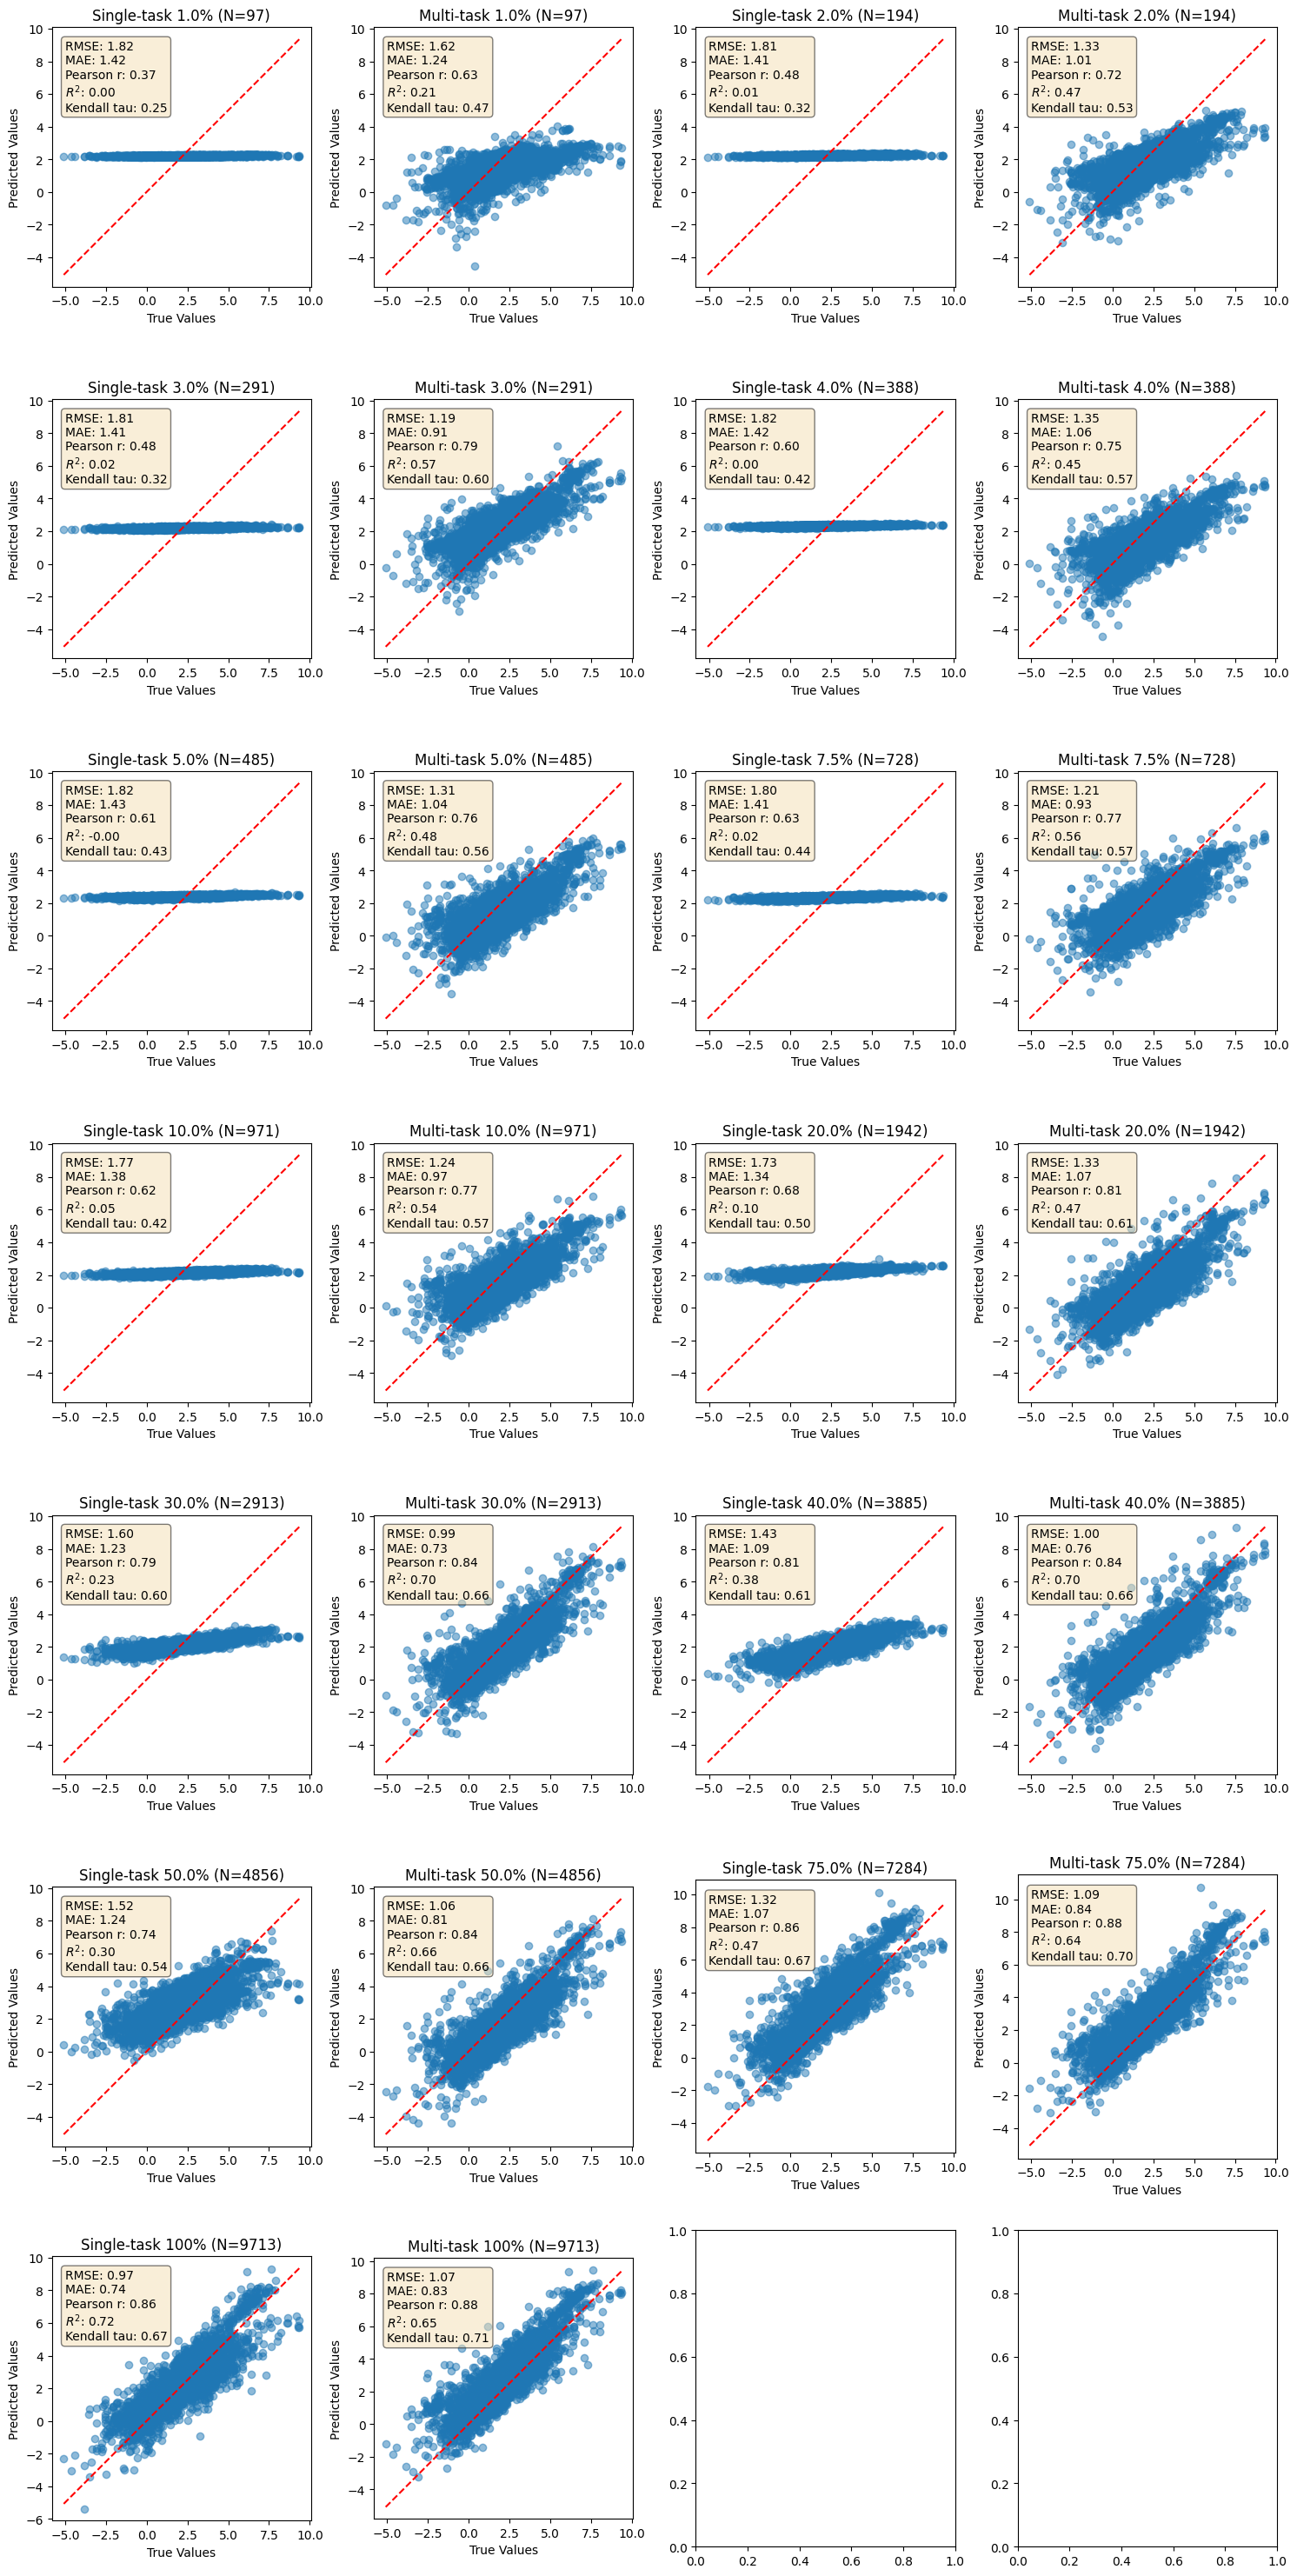

In [13]:
rows = len(sizes) // 2 + 1 if len(sizes) % 2 else len(sizes) // 2
cols = 4

fig, axs = plt.subplots(rows, cols, figsize=(15,30))  # Adjust the figure size as needed

axs = axs.flatten()

for i, s in enumerate(sizes):
    # Prepare data for single-task
    single_task_df = pd.read_csv(out_dir + f'{s}_STL/preds_0.csv')
    valid_single = single_task_df[['SMILES', "LogP", 'pred_0']].dropna()
    true_single_values = valid_single["LogP"]
    pred_single_values = valid_single['pred_0']

    # Prepare data for multi-task
    multi_task_df = pd.read_csv(out_dir + f'{s}_MTL/preds_0.csv')
    valid_multi = multi_task_df[['SMILES', "LogP", 'pred_0']].dropna()
    true_multi_values = valid_multi["LogP"]
    pred_multi_values = valid_multi['pred_0']

    # Plotting single-task
    plot_scatter_and_line(axs[2*i], true_single_values, pred_single_values, f'Single-task {s*100}% (N={int(len(stl_data)*s)})')

    # Plotting multi-task
    plot_scatter_and_line(axs[2*i+1], true_multi_values, pred_multi_values, f'Multi-task {s*100}% (N={int(len(stl_data)*s)})')

plt.tight_layout()
plt.show()

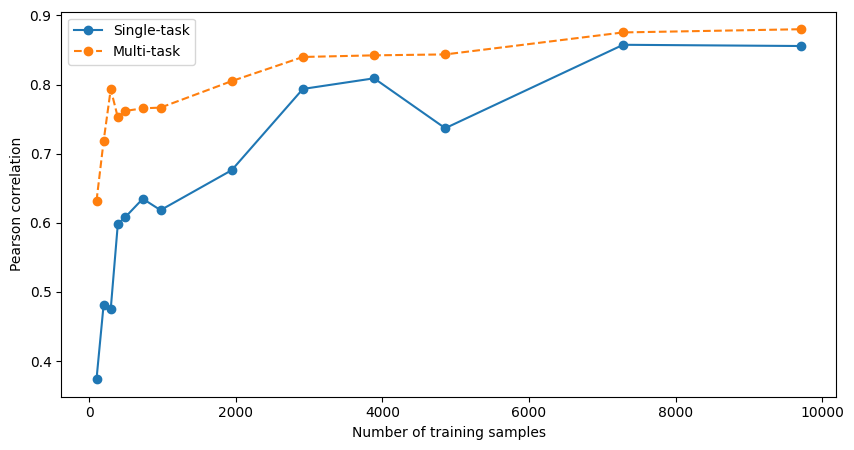

In [15]:
# Just plot the pearon correlation
from scipy.stats import pearsonr

pearson_corr = []

for s in sizes:
    # Prepare data for single-task
    single_task_df = pd.read_csv(out_dir + f'{s}_STL/preds_0.csv')
    valid_single = single_task_df[['SMILES', "LogP", 'pred_0']].dropna()
    true_single_values = valid_single["LogP"]
    pred_single_values = valid_single['pred_0']

    # Prepare data for multi-task
    multi_task_df = pd.read_csv(out_dir + f'{s}_MTL/preds_0.csv')
    valid_multi = multi_task_df[['SMILES', "LogP", 'pred_0']].dropna()
    true_multi_values = valid_multi["LogP"]
    pred_multi_values = valid_multi['pred_0']

    pearson_corr.append([s, pearsonr(true_single_values, pred_single_values)[0], pearsonr(true_multi_values, pred_multi_values)[0]])

pearson_corr = pd.DataFrame(pearson_corr, columns=["Size", "Single-task", "Multi-task"])
pearson_corr.set_index("Size", inplace=True)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot(pearson_corr.index*len(stl_data), pearson_corr["Single-task"], label="Single-task", marker='o')
plt.plot(pearson_corr.index*len(stl_data), pearson_corr["Multi-task"], label="Multi-task", marker='o', ls='--')

plt.xlabel("Number of training samples")
plt.ylabel("Pearson correlation")
plt.legend()

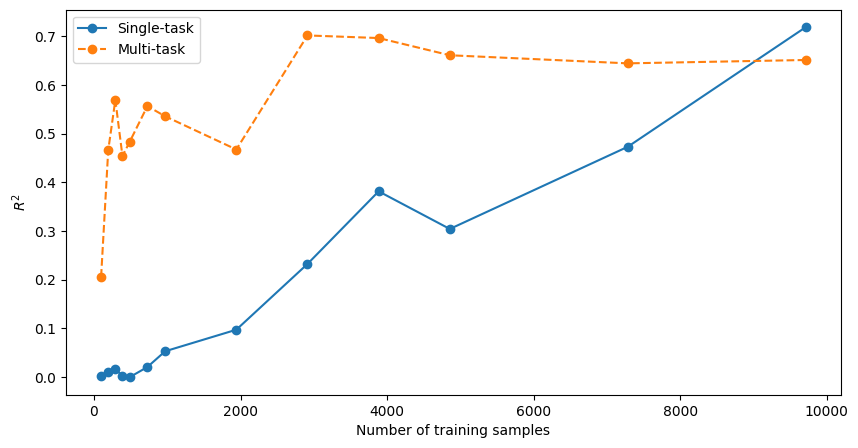

In [16]:
# Just plot the R2
from sklearn.metrics import r2_score

r2 = []

for s in sizes:
    # Prepare data for single-task
    single_task_df = pd.read_csv(out_dir + f'{s}_STL/preds_0.csv')
    valid_single = single_task_df[['SMILES', "LogP", 'pred_0']].dropna()
    true_single_values = valid_single["LogP"]
    pred_single_values = valid_single['pred_0']

    # Prepare data for multi-task
    multi_task_df = pd.read_csv(out_dir + f'{s}_MTL/preds_0.csv')
    valid_multi = multi_task_df[['SMILES', "LogP", 'pred_0']].dropna()
    true_multi_values = valid_multi["LogP"]
    pred_multi_values = valid_multi['pred_0']

    r2.append([s, r2_score(true_single_values, pred_single_values), r2_score(true_multi_values, pred_multi_values)])

r2 = pd.DataFrame(r2, columns=["Size", "Single-task", "Multi-task"])
r2.set_index("Size", inplace=True)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot(r2.index*len(stl_data), r2["Single-task"], label="Single-task", marker='o')
plt.plot(r2.index*len(stl_data), r2["Multi-task"], label="Multi-task", marker='o', ls='--')

plt.xlabel("Number of training samples")
plt.ylabel("$R^2$")
plt.legend()